The notebook is referened from https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd
It's a good article to understand DataLoader process.
This notebook should be running on Linux.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from itertools import *
from matplotlib.patches import Rectangle
from torch.utils.data import DataLoader, Dataset, IterableDataset

In [36]:
class MyMapDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        worker = torch.utils.data.get_worker_info()
        worker_id = worker.id if worker is not None else -1
        
        start = time.time()
        time.sleep(0.1)
        end = time.time()
        
        return self.data[idx], worker_id, start, end


In [37]:
data = list(range(17))

In [29]:
# copy from https://gist.github.com/david-macleod/2b933d28fd3ac09766785728ee191f09#file-plot_timings-py
def plot_timings(loader, n_batches, model_time=0.2, max_time=2.5):
    
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='black', linewidth=1)
    
    zero_time = time.time()
    
    worker_ids = {}
    worker_count = count()
        
    for result in islice(loader, n_batches):
        start = time.time()
        time.sleep(model_time)
        end = time.time()
                
        # check if already batched
        if isinstance(result[0], torch.Tensor):
            result = zip(*result)
            
        batch = []
        for item in result:
            data, worker, t1, t2 = tuple(map(scalar, item))
            
            # fix worker position in plot
            if worker != -1:
                if worker not in worker_ids:
                    worker_ids[worker] = next(worker_count)
                worker = worker_ids[worker]
   
            plot_time_box(data, worker, t1-zero_time, t2-zero_time, ax)
            batch.append(data)
        
        batch_str = ",".join(map(str, batch))
        plot_time_box(batch_str, -1, start-zero_time, end-zero_time, ax, color='firebrick')
    
    max_worker = len(worker_ids) - 1 
        
    ax.set_xlim(0, max_time)
    ax.set_ylim(-1.5, max_worker + 0.5)
    ax.set_xticks(np.arange(0, max_time, 0.2))
    ax.set_yticks(np.arange(-1, max_worker+1, 1))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', colors=(0,0,0,0))
    
    fig.set_figwidth(16)
    fig.set_figheight((max_worker + 2) * 0.5)
    
    ax.xaxis.label.set_color('gray')
    ax.tick_params(axis='x', colors='gray')
    for spine in ax.spines.values():
        spine.set_edgecolor((0,0,0,0))
        
def scalar(x):
    return x.item() if hasattr(x, 'item') else x

def plot_time_box(data, worker, t1, t2, ax, color='steelblue'):
    x = t1
    y = worker - 0.25
    w = t2 - t1
    h = 0.6
    
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='black',facecolor=color)
    
    ax.add_patch(rect)
    
    ax.text(x + (w * 0.5), y + (h * 0.5), str(data), va='center', ha='center', color='white', weight='bold')  

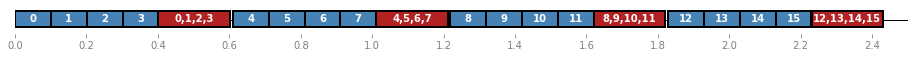

In [34]:
map_dataset = MyMapDataset(data)
loader = DataLoader(map_dataset, batch_size=4, num_workers=0)
plot_timings(loader, n_batches=4, model_time=0.2)

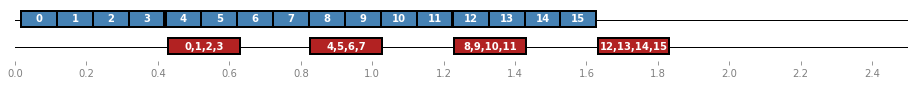

In [35]:
loader = DataLoader(map_dataset, batch_size=4, num_workers=1)
plot_timings(loader, n_batches=4, model_time=0.2)

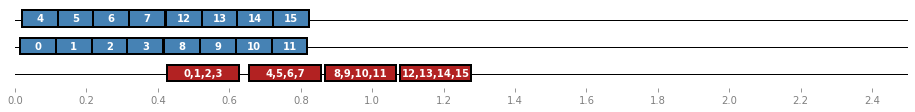

In [39]:
loader = DataLoader(map_dataset, batch_size=4, num_workers=2)
plot_timings(loader, n_batches=4, model_time=0.2)